# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,BatchNormalization
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.decomposition import PCA
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import random

2025-02-11 18:38:15.182341: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 18:38:15.187560: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 18:38:15.202766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739299095.218661   33120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739299095.223338   33120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 18:38:15.240967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
file_path = 'data/new_data_no_injured.xlsx'

# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df[df["Injury"]==1].sort_values(by="DATE", ascending=False).head(20)

,DATE,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,PlayerID,...,DEC_MSWR,Session_MD,Session_MD+1,Session_MD+2,Session_MD+3,Session_MD-1,Session_MD-2,Session_MD-3,Session_MD-4,Session_MD-5
1172,2025-01-21,1,NaN,NaN,2609.71,93.23,5.29,29.000000,27.0,98,...,0.844672,0,0,0,0,1,0,0,0,0
671,2025-01-16,1,NaN,NaN,411.78,0.00,0.00,0.000000,0.0,53,...,0.966695,1,0,0,0,0,0,0,0,0
1793,2025-01-09,1,NaN,NaN,4351.15,189.35,24.06,59.000000,47.0,134,...,1.040858,0,0,0,0,1,0,0,0,0
1282,2024-12-23,1,NaN,NaN,3994.16,462.50,33.30,74.000000,55.0,105,...,0.770324,0,0,0,0,1,0,0,0,0
54,2024-10-19,1,NaN,NaN,7690.38,280.94,56.40,79.000000,75.0,16,...,0.466528,1,0,0,0,0,0,0,0,0
53,2024-10-05,1,NaN,NaN,9989.17,275.93,110.63,93.000000,98.0,16,...,0.863202,0,0,0,0,1,0,0,0,0
406,2024-09-21,1,NaN,NaN,900.00,43.00,32.00,9.866667,10.8,48,...,0.842943,0,0,0,0,1,0,0,0,0
694,2024-08-27,1,NaN,NaN,4218.82,150.27,10.44,45.000000,39.0,66,...,1.797188,0,0,0,0,1,0,0,0,0
982,2024-08-17,1,NaN,NaN,5240.72,435.78,103.45,76.000000,68.0,93,...,0.928495,0,0,0,0,1,0,0,0,0
3915,2023-04-10,1,2022-2023,SEASON,1144.00,121.00,23.00,18.000000,11.0,20083,...,1.465774,0,0,0,0,1,0,0,0,0


Class imbalance:

In [3]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 6832
Lesión: 44
Porcentaje de lesionados en el dataset: 0.64%


# Correlation of variables

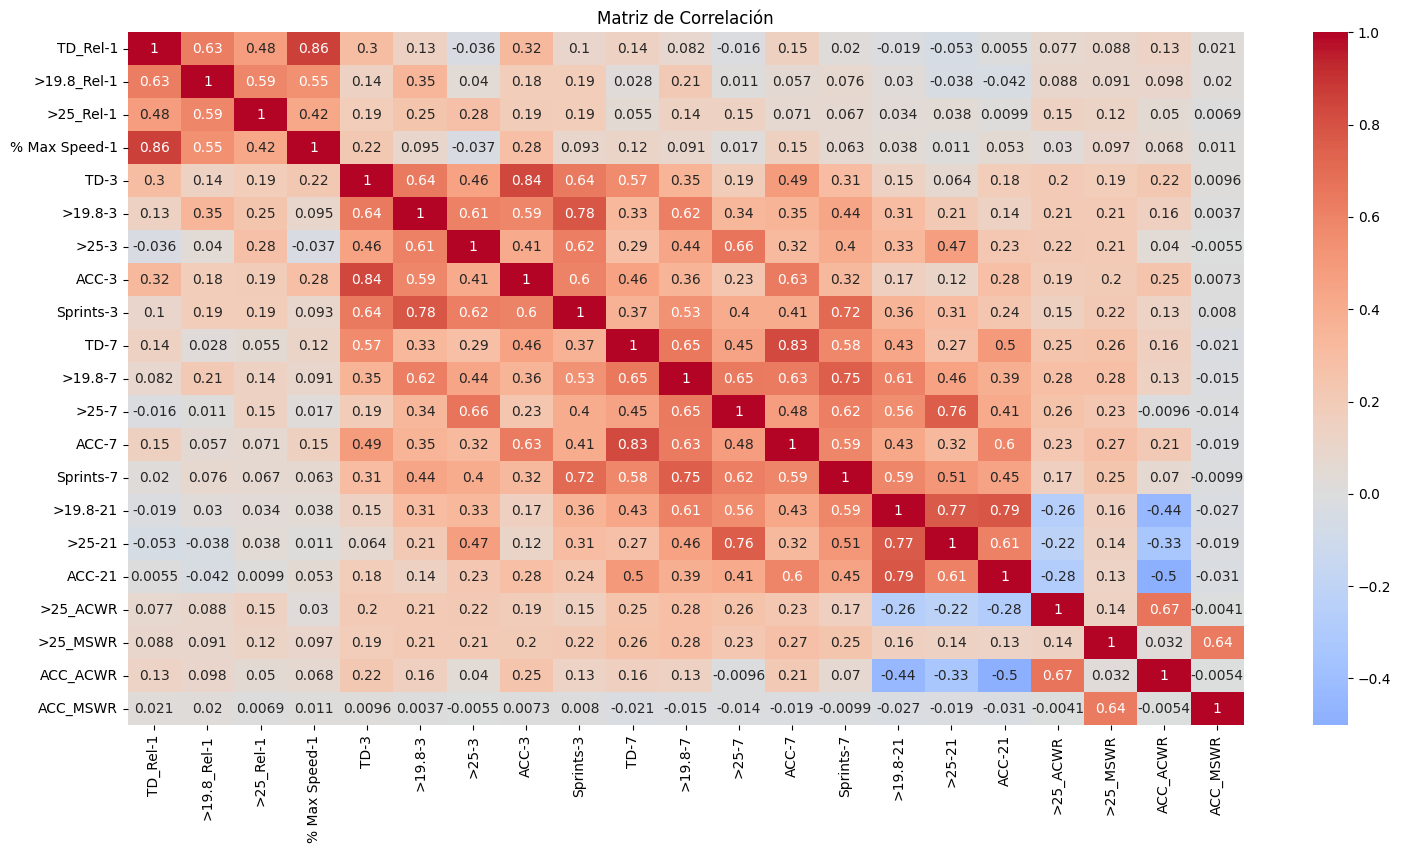

In [ ]:
metrics = ['TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'Sprints-7', '>19.8-21', '>25-21', 'ACC-21', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [ ]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

         Variable        VIF
0           const  37.345933
1        TD_Rel-1   5.109646
2     >19.8_Rel-1   2.770056
3       >25_Rel-1   1.909037
4   % Max Speed-1   3.997180
5            TD-3   9.880922
6         >19.8-3   7.585732
7           >25-3   4.094357
8           ACC-3   8.506115
9       Sprints-3  11.870469
10           TD-7   8.552423
11        >19.8-7   8.124830
12          >25-7   7.695737
13          ACC-7  11.795012
14      Sprints-7   9.889881
15       >19.8-21   7.369543
16         >25-21   6.673095
17         ACC-21   7.925699
18       >25_ACWR   3.024686
19       >25_MSWR   2.158119
20       ACC_ACWR   4.133702
21       ACC_MSWR   1.880967


# Filter data by date or season


In [4]:
# Season 2022-2023
# df_filtered = df[df['season']=='2022-2023']

# inj_2021 = df[(df['Injury'] == 1) & (df['season'] == '2021-2022')]
# df_filtered = pd.concat([df_filtered, inj_2021])

# Season 2021-2022
# df_filtered = df[df['season']=='2021-2022']

# Filter by no season
df_filtered = df.copy()

df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

df_sorted = df_filtered.sort_values(by='DATE', ascending=False).reset_index(drop=True)

In [5]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6614 entries, 0 to 6613
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              6614 non-null   datetime64[ns]
 1   Injury            6614 non-null   int64         
 2   season            3984 non-null   object        
 3   preseason-season  3984 non-null   object        
 4   TD                6614 non-null   float64       
 5   >19.8             6614 non-null   float64       
 6   >25               6614 non-null   float64       
 7   ACC               6614 non-null   float64       
 8   DEC               6614 non-null   float64       
 9   PlayerID          6614 non-null   int64         
 10  Sprints           6614 non-null   float64       
 11  Mins              6614 non-null   float64       
 12  % Max Speed       6611 non-null   float64       
 13  >19.8_Rel         6483 non-null   float64       
 14  >25_Rel           6483 n

# ML Models

## Select metrics to use for models

In [6]:
df.columns

Index(['DATE', 'Injury', 'season', 'preseason-season', 'TD', '>19.8', '>25',
       'ACC', 'DEC', 'PlayerID', 'Sprints', 'Mins', '% Max Speed', '>19.8_Rel',
       '>25_Rel', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1', 'TD-3',
       '>19.8-3', '>25-3', 'ACC-3', 'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7',
       '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21',
       'ACC-21', 'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR', 'Session_MD', 'Session_MD+1', 'Session_MD+2',
       'Session_MD+3', 'Session_MD-1', 'Session_MD-2', 'Session_MD-3',
       'Session_MD-4', 'Session_MD-5'],
      dtype='object')

In [53]:
# All data (Type of session included)
# metrics_train = ['Injury', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR','Session_MD', 'Session_MD+1', 'Session_MD+2',
#        'Session_MD+3', 'Session_MD-1', 'Session_MD-2', 'Session_MD-3',
#        'Session_MD-4', 'Session_MD-5']

# No session data
metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1','Mins-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR']

## No session data and no -21 data
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1','Mins-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_MSWR','>19.8_MSWR','>25_MSWR', 'ACC_MSWR','DEC_MSWR']

# > 19 >25 RELATIVE VALUES
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', '>19.8_Rel-1', '>25_Rel-1','% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR','Session_M+1', 'Session_M+2', 'Session_M+3',
#        'Session_M-1', 'Session_M-2', 'Session_M-3', 'Session_M-4',
#        'Session_M-5', 'Session_MD']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# No Relative values data
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR','Session_M+1', 'Session_M+2', 'Session_M+3',
#        'Session_M-1', 'Session_M-2', 'Session_M-3', 'Session_M-4',
#        'Session_M-5', 'Session_MD']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'Sprints-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', '>19.8-21', '>25-21', 'ACC-21', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

print(len(metrics_train))

39


## Split data

### Split by selecting X injuries and its past X days for testing the model, the rest of the injuries and its past X rows as training dataset.

In [57]:
import random

# Ensure the data is sorted by PlayerID and DATE
df_sorted = df_sorted.sort_values(by=['PlayerID', 'DATE']).reset_index(drop=True)

# Parameter: Number of injuries for the test set
num_test_injuries = 7  # Number of injuries to include in the test set

# Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 1: Randomly select indices for testing and training injuries
random.seed(42)  # Set seed for reproducibility
all_injury_indices = list(injury_rows.index)
test_injury_indices = random.sample(all_injury_indices, num_test_injuries)
train_injury_indices = list(set(all_injury_indices).difference(test_injury_indices))

# Step 2: Collect rows for testing set
test_indices = set(test_injury_indices)  # Start with rows where Injury == 1
rows_before_test = 10

for idx in test_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]

    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)

    # Collect the previous rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_test):injury_pos].index.tolist()
    test_indices.update(past_rows)

# Step 3: Collect rows for training set
train_indices = set(train_injury_indices)  # Start with rows where Injury == 1
rows_before_train = 80

for idx in train_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]

    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)

    # Collect the previous rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_train):injury_pos].index.tolist()
    train_indices.update(past_rows)

# Step 4: Remove duplicates from indices and ensure no overlap
test_indices = list(test_indices)
train_indices = list(set(train_indices).difference(test_indices))

# Step 5: Create the datasets
training = df_sorted.loc[train_indices]
testing = df_sorted.loc[test_indices]


# Get the columns in metrics_train and add the required columns
columns_to_keep = list(metrics_train) + ['PlayerID', 'DATE']

# Ensure there are no duplicates in the list
columns_to_keep = list(set(columns_to_keep))

X_train = training[metrics_train].reset_index(drop=True)
X_test_original = testing[columns_to_keep].reset_index(drop=True)
X_test = testing[metrics_train].reset_index(drop=True)
y_train = training['Injury'].reset_index(drop=True)
y_test = testing['Injury'].reset_index(drop=True)

In [54]:
# Check for overlap between X_train and X_test
common_rows = pd.merge(X_train, X_test, on=['DATE', 'PlayerID'], how='inner')

if common_rows.empty:
    print("No overlapping rows between X_train and X_test based on DATE and PlayerID.")
else:
    print("Overlapping rows found between X_train and X_test:")
    print(common_rows)

KeyError: 'DATE'

In [58]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")
print("No Lesión: " + str(X_test[X_test["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_test[X_test["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_test[X_test['Injury'] == 1].shape[0] / X_test.shape[0]) * 100):.2f}%")
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

No Lesión: 1831
Lesión: 35
Porcentaje de lesionados en el dataset: 1.88%
No Lesión: 69
Lesión: 8
Porcentaje de lesionados en el dataset: 10.39%


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TD-1           984 non-null    float64
 1   >19.8-1        984 non-null    float64
 2   >25-1          984 non-null    float64
 3   ACC-1          984 non-null    float64
 4   DEC-1          984 non-null    float64
 5   Sprints-1      984 non-null    int64  
 6   Mins-1         984 non-null    float64
 7   >19.8_Rel-1    984 non-null    float64
 8   >25_Rel-1      984 non-null    float64
 9   % Max Speed-1  984 non-null    float64
 10  TD-3           984 non-null    float64
 11  >19.8-3        984 non-null    float64
 12  >25-3          984 non-null    float64
 13  ACC-3          984 non-null    float64
 14  DEC-3          984 non-null    float64
 15  Sprints-3      984 non-null    float64
 16  TD-7           984 non-null    float64
 17  >19.8-7        984 non-null    float64
 18  >25-7     

### Split by first %X for validating and rest for training

In [16]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for X% testing
percentage_validation = 0.3
split_index = int(percentage_validation * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index].reset_index(drop=True)
X_train = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[:split_index].reset_index(drop=True)
y_train = y.iloc[split_index:].reset_index(drop=True)
extra_cols_test = extra_cols.iloc[:split_index].reset_index(drop=True)
extra_cols_train = extra_cols.iloc[split_index:].reset_index(drop=True)

Select less amount of data

In [ ]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 2883
Lesión: 22
Porcentaje de lesionados en el dataset: 0.76%


In [ ]:
# Sort X_train by index
X_train = X_train.sort_index()  # Sort by date or relevant index if not already sorted.
y_train = y_train.sort_index()  # Ensure y_train matches X_train in order.

# Filter rows where 'Injury' == 1
injury_rows = X_train[X_train['Injury'] == 1]

# Get 30 days before each injury
# Assuming a datetime index, otherwise adjust for your date representation
indices_to_include = set(injury_rows.index)

for idx in injury_rows.index:
    # Include 30 rows before the 'Injury == 1', ensure not out of bounds
    start_idx = max(0, idx - 30)
    indices_to_include.update(range(start_idx, idx + 1))

# Create a dataframe with required rows (Injury == 1 and 30 days before)
selected_rows = X_train.loc[list(indices_to_include)]
selected_y = y_train.loc[selected_rows.index]  # Match y_train with selected rows

# Get the remaining rows not in `selected_rows`
remaining_rows = X_train.drop(selected_rows.index)
remaining_y = y_train.drop(selected_y.index)

# Proportion for sampling (e.g., 50%)
sample_proportion = 0.5
n_to_sample = int(len(X_train) * sample_proportion - len(selected_rows))

# Randomly sample from the remaining rows
sampled_rows = remaining_rows.sample(n=n_to_sample, random_state=42)
sampled_y = remaining_y.loc[sampled_rows.index]

# Combine the selected rows and sampled rows
X_train = pd.concat([selected_rows, sampled_rows]).sort_index().reset_index(drop=True)
y_train = pd.concat([selected_y, sampled_y]).sort_index().reset_index(drop=True)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Injury      809 non-null    int64  
 1   TD-1        809 non-null    float64
 2   >19.8-1     809 non-null    int64  
 3   >25-1       809 non-null    int64  
 4   ACC-1       809 non-null    float64
 5   DEC-1       809 non-null    float64
 6   Sprints-1   809 non-null    int64  
 7   TD-3        809 non-null    float64
 8   >19.8-3     809 non-null    float64
 9   >25-3       809 non-null    int64  
 10  ACC-3       809 non-null    float64
 11  DEC-3       809 non-null    float64
 12  Sprints-3   809 non-null    int64  
 13  TD-7        809 non-null    float64
 14  >19.8-7     809 non-null    float64
 15  >25-7       809 non-null    int64  
 16  ACC-7       809 non-null    float64
 17  DEC-7       809 non-null    float64
 18  Sprints-7   809 non-null    int64  
 19  TD-21       809 non-null    f

In [ ]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 789
Lesión: 20
Porcentaje de lesionados en el dataset: 2.47%


In [ ]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split random

In [72]:
X = df_sorted[list(metrics_train)]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test_original = X_test.copy()

# X_train.drop(columns=['Injury', 'PlayerID', 'DATE'], inplace=True)
# X_test.drop(columns=['Injury', 'PlayerID', 'DATE'], inplace=True)

X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

## SMOTE or SMOTEEN oversampling technique

In [55]:
# Apply SMOTE to training data
# smote = SMOTE(random_state=42)
# X_train , y_train = smote.fit_resample(X_train, y_train)

# Apply SMOTEEN to training data
# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

from imblearn.combine import SMOTETomek

# Apply SMOTE-Tomek to training data
smote_tomek = SMOTETomek(random_state=42)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    4597
1    4597
Name: count, dtype: int64
Injury
0    4597
1    4597
Name: count, dtype: int64


## Standarizacion

#### CON Session en data

In [71]:
no_scaled = ['Session_MD+1', 'Session_MD+2', 'Session_MD+3',
       'Session_MD-1', 'Session_MD-2', 'Session_MD-3', 'Session_MD-4',
       'Session_MD-5', 'Session_MD']

# Initialize the scaler
scaler = StandardScaler()

# Columns to scale: exclude those in no_scaled
scaled_columns = [col for col in X_train.columns if col not in no_scaled]

# Scale only the selected columns
X_train_scaled_part = scaler.fit_transform(X_train[scaled_columns])
X_test_scaled_part = scaler.transform(X_test[scaled_columns])

# Convert scaled parts back to DataFrame
X_train_scaled_part = pd.DataFrame(X_train_scaled_part, columns=scaled_columns, index=X_train.index)
X_test_scaled_part = pd.DataFrame(X_test_scaled_part, columns=scaled_columns, index=X_test.index)

# Add the unscaled columns back
X_train_scaled = pd.concat([X_train_scaled_part, X_train[no_scaled]], axis=1)
X_test_scaled = pd.concat([X_test_scaled_part, X_test[no_scaled]], axis=1)

# Ensure column order matches the original
X_train_scaled = X_train_scaled[X_train.columns]
X_test_scaled = X_test_scaled[X_test.columns]

KeyError: "None of [Index(['Session_MD+1', 'Session_MD+2', 'Session_MD+3', 'Session_MD-1',\n       'Session_MD-2', 'Session_MD-3', 'Session_MD-4', 'Session_MD-5',\n       'Session_MD'],\n      dtype='object')] are in the [columns]"

#### Sin sessions en metricas

In [73]:
# Initialize the scaler
scaler = StandardScaler()

# Scale only the selected columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

### Regular logistic regression

In [12]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.933898673624701
Confusion Matrix:
 [[4083  516]
 [  92 4507]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      4599
           1       0.90      0.98      0.94      4599

    accuracy                           0.93      9198
   macro avg       0.94      0.93      0.93      9198
weighted avg       0.94      0.93      0.93      9198


Test Set Evaluation:
Accuracy: 0.8790931989924433
Confusion Matrix:
 [[1741  231]
 [   9    4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.94      1972
           1       0.02      0.31      0.03        13

    accuracy                           0.88      1985
   macro avg       0.51      0.60      0.48      1985
weighted avg       0.99      0.88      0.93      1985



Find the best threshold

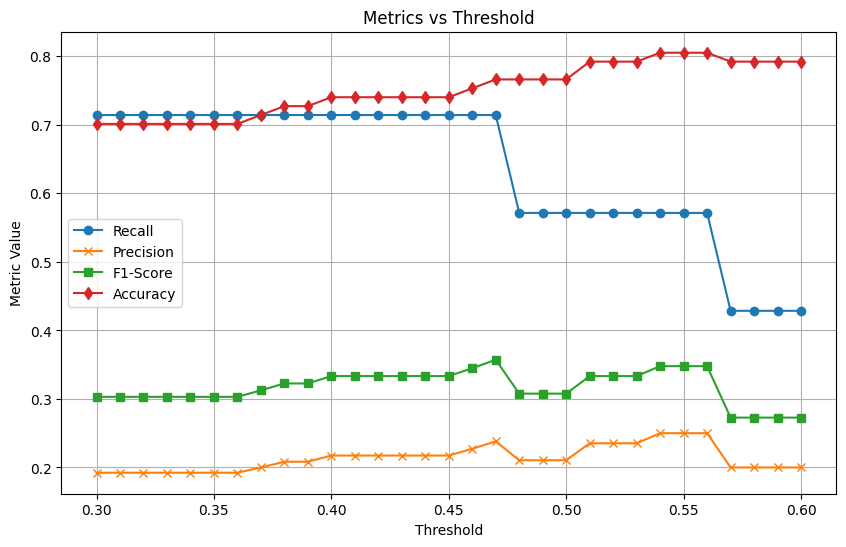

In [ ]:
# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs >= threshold).astype(int)

    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

ROC Curve with manually selecting the threshold

Number of unique thresholds: 13

Manually Selected Threshold: 0.40

Evaluation with Manually Selected Threshold:
Accuracy: 0.7402597402597403
Confusion Matrix:
 [[52 18]
 [ 2  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.74      0.84        70
           1       0.22      0.71      0.33         7

    accuracy                           0.74        77
   macro avg       0.59      0.73      0.59        77
weighted avg       0.90      0.74      0.79        77



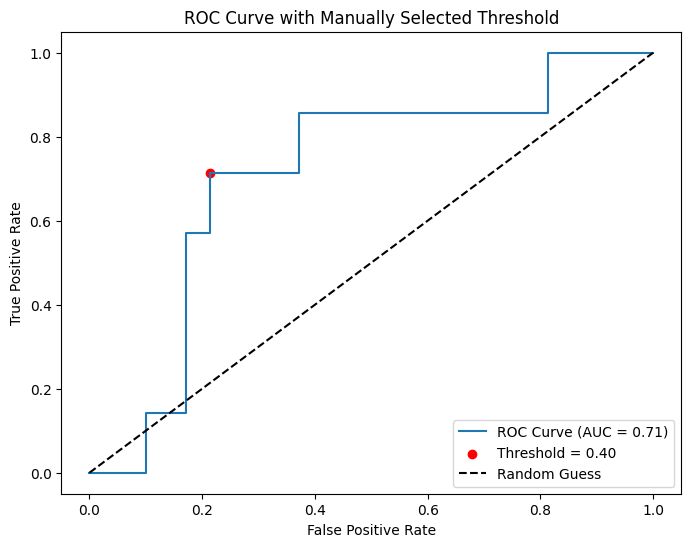

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.4 # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

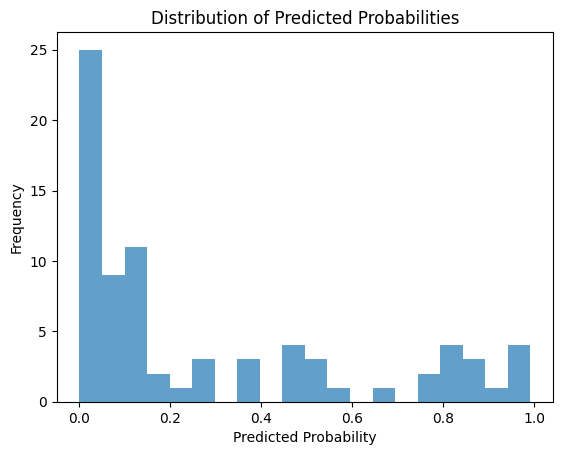

In [ ]:
plt.hist(y_test_probs, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Store the coeficients

In [ ]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_probs,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()


NameError: name 'extra_cols_test' is not defined

Find the features that affect the injuries the most

In [ ]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

           Feature  Importance
24       Sprints-7    2.161744
7         TD_Rel-1    1.878728
4            DEC-1    1.585965
27          >25-21    1.453410
31         TD_ACWR    1.439439
12   % Max Speed-1    1.173611
13            TD-3    1.149488
35        >25_ACWR    0.937900
40        DEC_MSWR    0.836031
16           ACC-3    0.697221
15           >25-3    0.558649
22           ACC-7    0.438215
23           DEC-7    0.391108
38        ACC_MSWR    0.373578
2            >25-1    0.341091
14         >19.8-3    0.181219
36        >25_MSWR    0.164959
5        Sprints-1    0.130115
29          DEC-21    0.075791
33      >19.8_ACWR   -0.016715
39        DEC_ACWR   -0.086644
20         >19.8-7   -0.092862
8      >19.8_Rel-1   -0.127035
28          ACC-21   -0.299928
25           TD-21   -0.340709
11       DEC_Rel-1   -0.420705
6           Mins-1   -0.542277
19            TD-7   -0.560830
3            ACC-1   -0.579644
26        >19.8-21   -0.641157
17           DEC-3   -0.712210
1       

Select X quantity of the top features and retrain the model

In [ ]:
# Extract top features by absolute importance
num_top_features =  20 # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 20 Features: ['Sprints-7' 'TD_Rel-1' 'DEC-1' '>25-21' 'TD_ACWR' '% Max Speed-1' 'TD-3'
 '>25_ACWR' 'DEC_MSWR' 'ACC-3' '>25-3' 'ACC-7' 'DEC-7' 'ACC_MSWR' '>25-1'
 '>19.8-3' '>25_MSWR' 'Sprints-1' 'DEC-21' '>19.8_ACWR']


In [ ]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000)
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs_top >= threshold).astype(int)

    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

InvalidIndexError: (slice(None, None, None), [24, 7, 4, 27, 31, 12, 13, 35, 40, 16, 15, 22, 23, 38, 2, 14, 36, 5, 29, 33])

Number of unique thresholds: 11

Manually Selected Threshold: 0.40

Evaluation with Manually Selected Threshold:
Accuracy: 0.43636363636363634
Confusion Matrix:
 [[20 30]
 [ 1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.40      0.56        50
           1       0.12      0.80      0.21         5

    accuracy                           0.44        55
   macro avg       0.54      0.60      0.38        55
weighted avg       0.88      0.44      0.53        55



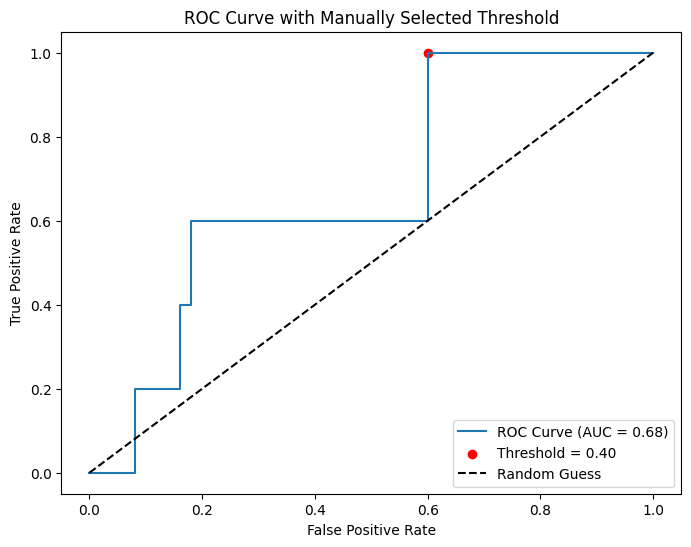

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.4  # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs_top >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

## ANN

In [74]:
# metrics_ANN =  ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
#  'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
#  'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']
metrics_ANN = metrics_train

In [75]:
from imblearn.over_sampling import SMOTENC, ADASYN

# Step 1: Split the original dataset (before applying SMOTE)

X_train_ann_bs, X_val, y_train_ann_bs, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)
# Step 2: Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
# sm = SMOTENC(categorical_features=[index_of_categorical_columns], random_state=42)

X_train_ann, y_train_ann = smote.fit_resample(X_train_ann_bs, y_train_ann_bs)

In [76]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define learning rate schedule: initial learning rate 0.0001 with exponential decay rate 0.96
initial_learning_rate = 0.0001
# Adjust 'decay_steps' based on your dataset size or desired decay schedule.
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,    # For example: every 10,000 steps, the LR decays.
    decay_rate=0.98,
    staircase=True       # If True, the learning rate decays in discrete intervals.
)

# Define constants based on the specification
INPUT_DIM = X_train_ann.shape[1]   
HIDDEN_LAYER1_UNITS = 128  # Hidden layer 1: 200 neurons
HIDDEN_LAYER2_UNITS = 64  # Hidden layer 2: 100 neurons
HIDDEN_LAYER3_UNITS = 32
HIDDEN_LAYER4_UNITS = 26
DROPOUT_RATE = 0.5         # Dropout rate for both dropout layers
EPOCHS = 50

BATCH_SIZE = 256

class ProgressiveDropout(tf.keras.callbacks.Callback):
    def __init__(self, initial_rate=0.5, final_rate=0.2, total_epochs=50):
        self.initial_rate = initial_rate
        self.final_rate = final_rate
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        # Calculate current dropout rate based on epoch
        current_rate = self.initial_rate - (epoch / self.total_epochs) * (self.initial_rate - self.final_rate)
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                layer.rate = current_rate

# Add ProgressiveDropout to model callbacks
dropout_callback = ProgressiveDropout(initial_rate=0.5, final_rate=0.2, total_epochs=50)

from tensorflow.keras.layers import GaussianNoise

# Define the ANN model with regularization
def create_ann(input_dim):
    model = Sequential([
        Dense(HIDDEN_LAYER1_UNITS, activation='relu', input_dim=input_dim, kernel_initializer=GlorotUniform()),
        #BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_LAYER2_UNITS, activation='relu', kernel_regularizer=l2(0.01)),
        #BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        # Dense(HIDDEN_LAYER3_UNITS, activation='relu',kernel_regularizer=l2(0.01)),
        # #BatchNormalization(),
        # Dropout(DROPOUT_RATE),

        # Dense(HIDDEN_LAYER4_UNITS, activation='relu', kernel_regularizer=l2(0.01)),
        # #BatchNormalization(),
        # Dropout(DROPOUT_RATE),

        Dense(1, activation='sigmoid')
    ])
     
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create the model
model = create_ann(INPUT_DIM)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights_dict = {0: 1.0, 1: 1.0}

# Training the model
history = model.fit(
    X_train_ann,
    y_train_ann,
    epochs=EPOCHS,  
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping, dropout_callback],
    class_weight=class_weights_dict  
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Get probabilities for the test set as percentages
probabilities = model.predict(X_test_scaled)

Epoch 1/50


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4932 - loss: 1.5830 - val_accuracy: 0.6382 - val_loss: 1.4794
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5375 - loss: 1.5272 - val_accuracy: 0.6663 - val_loss: 1.4327
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5491 - loss: 1.4844 - val_accuracy: 0.6825 - val_loss: 1.3892
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5674 - loss: 1.4335 - val_accuracy: 0.7009 - val_loss: 1.3488
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5977 - loss: 1.3969 - val_accuracy: 0.7127 - val_loss: 1.3096
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6156 - loss: 1.3600 - val_accuracy: 0.7257 - val_loss: 1.2741
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6345 - loss: 1.3178 - val_accuracy: 0.7376 - val_loss: 1.2399
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6590 - loss: 1.2834 - val_accuracy: 0.7495 - val_loss: 1.2050
Ep

In [77]:
# Get predictions (rounded to 0 or 1)
y_pred = (probabilities > 0.35).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[1568  404]
 [   7    6]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.88      1972
           1       0.01      0.46      0.03        13

    accuracy                           0.79      1985
   macro avg       0.51      0.63      0.46      1985
weighted avg       0.99      0.79      0.88      1985



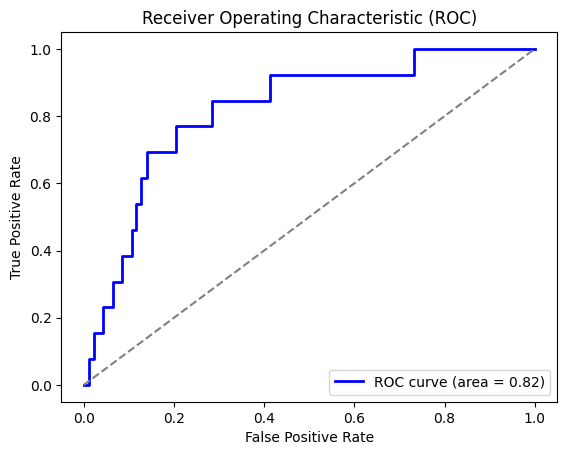

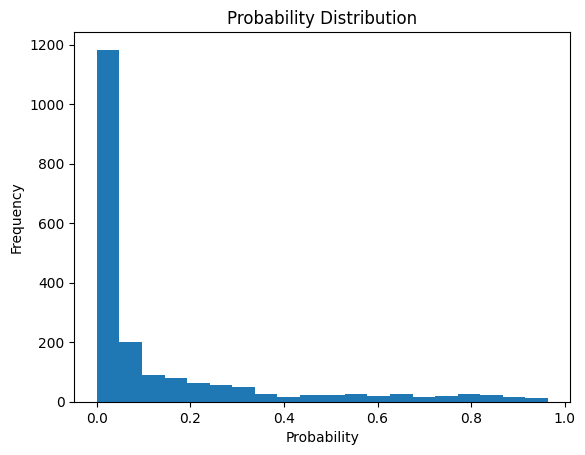

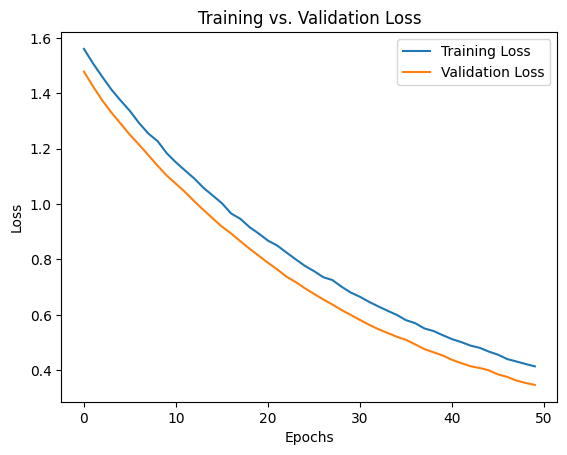

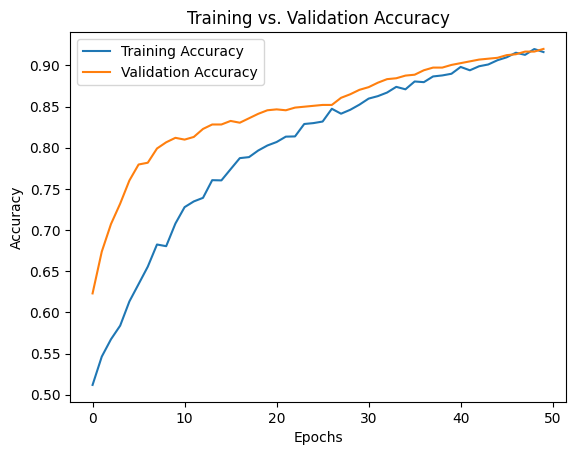

In [50]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

plt.hist(probabilities, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.show()

In [191]:
# import joblib
# joblib.dump(model, 'ann_model_ns.pkl')

['ann_model_ns.pkl']

In [34]:
# Convert the probabilities to a pandas DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=['Probability'])

# Combine the probabilities with the original test data into a new DataFrame
new_df = pd.concat([X_test_original.reset_index(drop=True), probabilities_df], axis=1)

new_df = new_df[['DATE', 'PlayerID', 'Injury', 'Probability'] + list(metrics_train)]

# Si lo queres ver en excel
# new_df.to_excel('probabilities_test.xlsx', index=False)

# Display the first few rows to confirm
new_df.head()

,DATE,PlayerID,Injury,Probability,Injury,TD-1,>19.8-1,>25-1,ACC-1,DEC-1,...,TD_ACWR,TD_MSWR,>19.8_ACWR,>19.8_MSWR,>25_ACWR,>25_MSWR,ACC_ACWR,ACC_MSWR,DEC_ACWR,DEC_MSWR
0,2023-01-13,25467,0,0.440147,0,0.0,0,0,0.0,0.0,...,0.952110,1.358201,1.016231,0.722174,1.414747,0.531866,0.903571,1.378828,0.888055,1.261059
1,2023-01-14,25467,0,0.622148,0,2776.0,71,42,36.0,36.0,...,0.934888,1.300942,1.098351,0.748006,1.562104,0.621398,0.894535,1.323652,0.904018,1.266429
2,2023-01-15,25467,0,0.020473,0,5201.0,296,183,44.0,46.0,...,0.923249,1.303603,0.715450,0.981185,1.443715,0.666329,0.850223,1.281122,0.895289,1.263556
3,2023-01-17,25467,0,0.009152,0,0.0,0,0,0.0,0.0,...,0.864881,1.231779,0.711956,0.792901,1.662039,0.664040,0.782055,1.126656,0.798931,1.146944
4,2023-01-18,25467,0,0.575904,0,4493.0,86,2,98.0,78.0,...,0.874692,1.242978,0.721994,0.778456,1.774648,0.668613,0.771557,1.051665,0.761207,1.127738


### SHAP for ANN

PermutationExplainer explainer: 1986it [01:51, 17.81it/s]                          


SHAP values shape: (1985, 47)
X_test_scaled shape: (1985, 47)


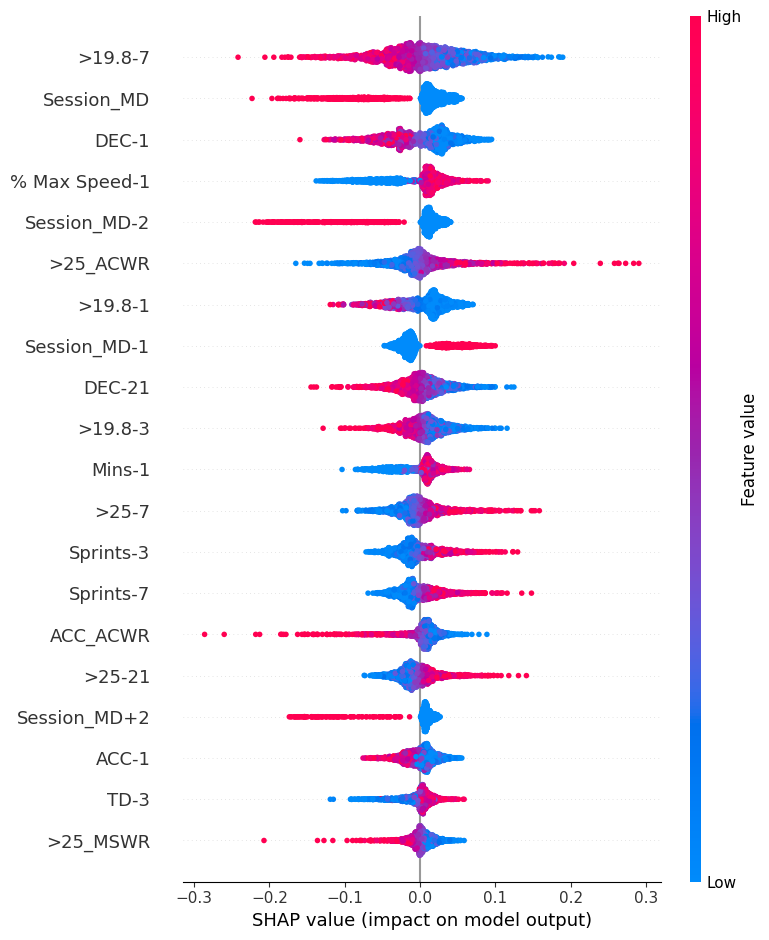

In [52]:
import shap

# Convert inputs to NumPy (in case they are Pandas DataFrames)
X_train_np = X_train_scaled.to_numpy() if hasattr(X_train_scaled, "to_numpy") else X_train_scaled
X_test_np = X_test_scaled.to_numpy() if hasattr(X_test_scaled, "to_numpy") else X_test_scaled

# Use the generic SHAP Explainer (handles DeepExplainer internally)
explainer = shap.Explainer(model, X_train_np)

# Compute SHAP values
shap_values = explainer(X_test_np)

# Convert to NumPy if needed
shap_values_np = shap_values.values if hasattr(shap_values, "values") else shap_values

# Check shapes
print("SHAP values shape:", shap_values_np.shape)
print("X_test_scaled shape:", X_test_np.shape)

# Visualize SHAP values
shap.summary_plot(shap_values_np, X_test_np, feature_names=X_train.columns)


In [16]:
# Step 1: Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Step 2: Create a DataFrame to store feature importance
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean SHAP Value': mean_shap_values
}).sort_values(by='Mean SHAP Value', ascending=False)

print("Feature importance:")
print(shap_importance)

NameError: name 'shap_values' is not defined

In [ ]:
# Step 3: Select the top X features
X = 15  # Number of top features to select
top_features = shap_importance['Feature'].head(X).tolist()

print(f"Top {X} features:", top_features)

Top 15 features: ['>25_MSWR', 'DEC-7', '>19.8-7', 'Sprints-3', 'ACC-7', '>25-7', 'ACC-3', 'TD_Rel-1', '>19.8-3', 'ACC_MSWR', 'ACC-1', 'TD-1', 'Mins-1', '>19.8_MSWR', 'DEC_MSWR']


## XGBoost Model

### Grid Search XGBoost

In [98]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.005, 0.007, 0.01],
    'max_depth': [7, 9, 11,13,15],
    'n_estimators': [300,500,700],
    'scale_pos_weight': [9,10,12,15],
    'alpha': [0],
    'gamma': [0],
}

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train)
X_test_selected = scaler.transform(X_test)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits


KeyboardInterrupt: 

### Manual XGBoost

Final Test ROC-AUC: 0.7817
Confusion Matrix:
[[1808  164]
 [   8    5]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.95      1972
           1       0.03      0.38      0.05        13

    accuracy                           0.91      1985
   macro avg       0.51      0.65      0.50      1985
weighted avg       0.99      0.91      0.95      1985



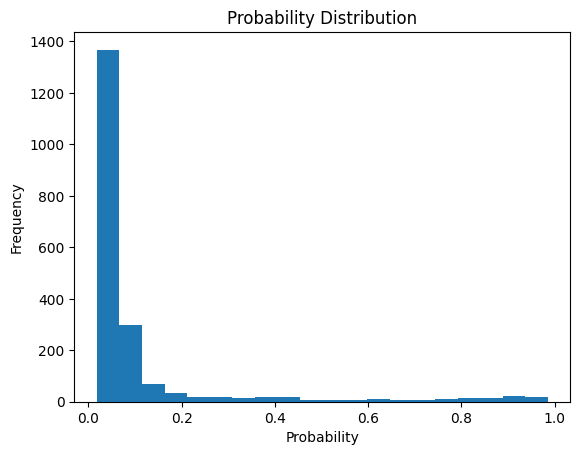

In [69]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.9
}

param_grid = {
  'learning_rate':0.007,  # Explore smaller learning rates
  'max_depth':15,            # Test broader depth values
  'n_estimators':400,     # Include larger estimators
  'scale_pos_weight': 11,
  'alpha': 0,  # L regularization
  'gamma': 0,  # Minimum loss reduction
}

# Big Dataset:

# SMOTEKK
# Final Test ROC-AUC: 0.9019
# Confusion Matrix:
# [[1829  143]
#  [   5    8]]

# SMOTE
# Final Test ROC-AUC: 0.8800
# Confusion Matrix:
# [[1840  132]
#  [   5    8]]

# param_grid = {
#   'learning_rate':0.005,  # Explore smaller learning rates
#   'max_depth':14,            # Test broader depth values
#   'n_estimators':500,     # Include larger estimators
#   'scale_pos_weight': 9,
#   'alpha': 0,  # L regularization
#   'gamma': 0,  # Minimum loss reduction
# }

# Reduced Dataset

# Final Test ROC-AUC: 0.8025
# Confusion Matrix:
# [[58 11]
#  [ 3  5]]

# param_grid = {
#   'learning_rate':0.005,  # Explore smaller learning rates
#   'max_depth':15,            # Test broader depth values
#   'n_estimators':400,     # Include larger estimators
#   'scale_pos_weight': 11,
#   'alpha': 0,  # L regularization
#   'gamma': 0,  # Minimum loss reduction
# }

# Final Test ROC-AUC: 0.7971
# Confusion Matrix:
# [[62  7]
#  [ 3  5]]
# param_grid = {
#   'learning_rate':0.005,  # Explore smaller learning rates
#   'max_depth':15,            # Test broader depth values
#   'n_estimators':500,     # Include larger estimators
#   'scale_pos_weight': 12,
#   'alpha': 0,  # L regularization
#   'gamma': 0,  # Minimum loss reduction
# }

X_train_scaled = X_train
X_test_scaled = X_test

# pca = PCA(n_components=30)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# Train the model with manually selected parameters
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_scaled,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_scaled)[:, 1]
# Apply custom threshold
threshold = 0.35
y_pred = (y_pred_probs >= threshold).astype(int)

test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

plt.hist(y_pred_probs, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [37]:
import joblib
joblib.dump(final_model, 'xgb_model_ns_2.pkl')

['xgb_model_ns_2.pkl']

In [33]:
# Get probabilities from XGBoost
xgboost_probabilities = y_pred_probs

# Convert the probabilities to a pandas DataFrame
xgboost_probabilities_df = pd.DataFrame(xgboost_probabilities, columns=['Probability'])

# Combine probabilities with X_test_original into a new DataFrame
new_xgboost_df = pd.concat([X_test_original.reset_index(drop=True), xgboost_probabilities_df], axis=1)

# Define the desired column order
column_order_xgboost = ['DATE', 'PlayerID', 'Probability'] + list(metrics_train)

# Ensure the columns exist in the new DataFrame and reorder them
new_xgboost_df = new_xgboost_df[[col for col in column_order_xgboost if col in new_xgboost_df.columns]]

# Display the first few rows to confirm
new_xgboost_df.head()

,DATE,PlayerID,Probability,Injury,TD-1,>19.8-1,>25-1,ACC-1,DEC-1,Sprints-1,...,DEC_MSWR,Session_MD,Session_MD+1,Session_MD+2,Session_MD+3,Session_MD-1,Session_MD-2,Session_MD-3,Session_MD-4,Session_MD-5
0,2024-09-23,16,0.171636,0,3025.02,33.41,0.00,39.0,29.0,0,...,0.959459,0,1,0,0,0,0,0,0,0
1,2024-09-24,16,0.264506,0,3195.90,31.33,5.88,47.0,35.0,1,...,1.275524,0,0,0,0,1,0,0,0,0
2,2024-09-26,16,0.364544,0,0.00,0.00,0.00,0.0,0.0,0,...,0.768163,1,0,0,0,0,0,0,0,0
3,2024-09-27,16,0.419148,0,1382.87,0.00,0.00,1.0,0.0,0,...,0.755057,0,0,0,0,0,1,0,0,0
4,2024-09-28,16,0.435049,0,2231.84,13.60,0.00,28.0,25.0,0,...,0.759287,0,0,0,0,1,0,0,0,0


In [22]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

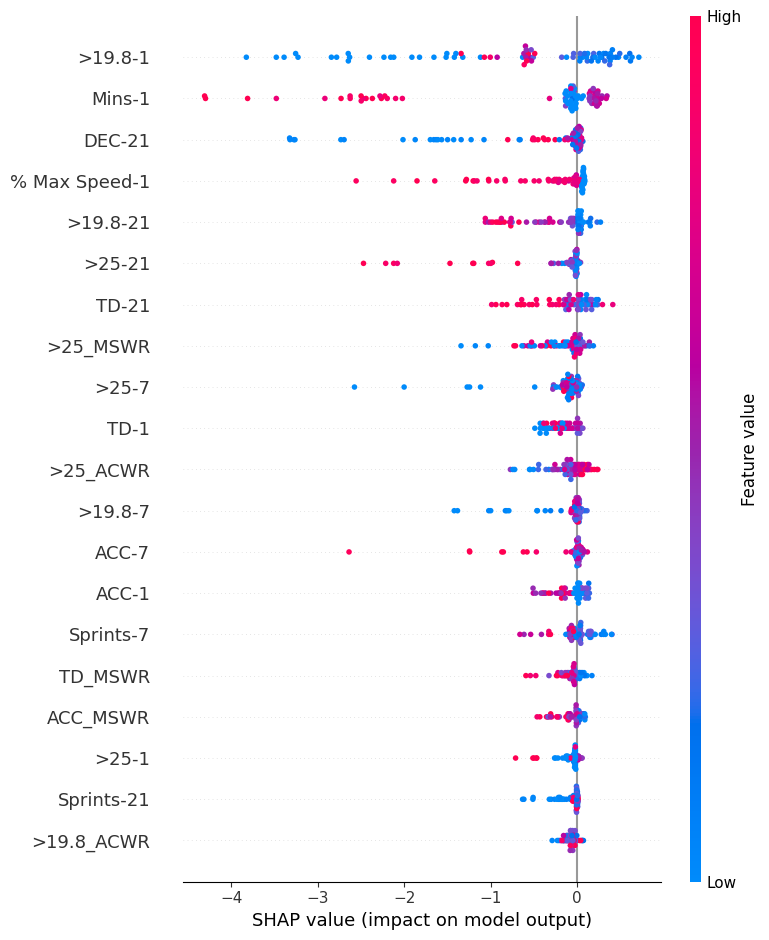

In [23]:
shap.summary_plot(shap_values, X_test_scaled)

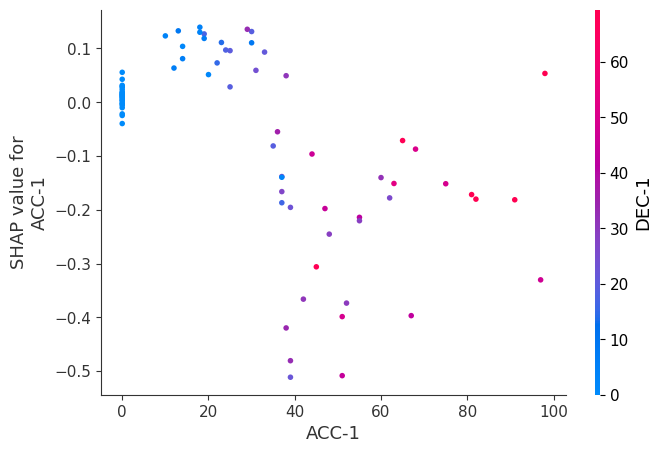

In [24]:
shap.dependence_plot("ACC-1", shap_values, X_test, interaction_index="DEC-1")

## Prepare the data to export in excel

Categorize the percentages into levels of risk

In [ ]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'